# Deep Metal: A Sentiment Analysis Classifier 
 
<a href="mailto:alexander.sack@mg.thedataincubator.com">Alexander Sack</a>

##### The Data Incubator
##### Winter 2019

# What is Sentiment Analysis?


# Why DeepMetal?

* Combine my passion for music with my one for data science
    - I'm a co-founder of the website [Metal-Fi](http://www.metal-fi.com)
    - A guest writer for the blog [Angry Metal-Guy](http://www.angrymetalguy.com), one the most popular metal sites on the web with over a million views per month.

* There are certain questions that *need* answers:
    - Is sentiment 

In [243]:
import numpy as np
import pandas as pd
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
import json
import time
import wordcloud
import os
import seaborn as sns
%matplotlib inline

from collections import Counter

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy import displacy
nlp = spacy.load('en_core_web_lg')

from math import pi

import sklearn.preprocessing as pr
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from bokeh.embed import file_html
from bokeh.resources import CDN
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import BasicTicker, ColumnDataSource, ColorBar, Title, LinearColorMapper, PrintfTickFormatter, LogColorMapper, NumeralTickFormatter, LabelSet, HoverTool
from bokeh.palettes import Category20c, Inferno256, Magma256, Greys256, Spectral6, Viridis256, linear_palette
from bokeh.transform import cumsum, linear_cmap, jitter, transform
from bokeh.layouts import row, column
output_notebook()

Loading BokehJS ...

In [224]:
if os.path.exists('data/checkpoint.csv'):
    df = pd.read_csv('data/checkpoint.csv')
else:
    df = pd.read_csv('data/reviews.csv')
    df['formedin'].fillna(0, inplace = True)
    df['formedin'] = df['formedin'].apply(int)
    df['formedin_dt'] = pd.to_datetime(df['formedin'], errors = 'coerce', format = '%Y')
    df['rating_n'] = df['rating'].str.rstrip('%').astype('float')/100.0
df['date_dt'] = pd.to_datetime(df['date'], errors = 'coerce')

In [225]:
# 80% ratings or higher are considered a positive review
POSITIVE_THRESHOLD = 0.8
def calc_sentiment(rating):
    if rating >= POSITIVE_THRESHOLD:
        return 1
    else:
        return 0
df['sentiment'] = df['rating_n'].apply(lambda x: calc_sentiment(x))

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100626 entries, 0 to 100625
Data columns (total 23 columns):
bid              100626 non-null int64
name             100626 non-null object
origin           100626 non-null object
location         99497 non-null object
status           100626 non-null object
formedin         100626 non-null int64
genre            100626 non-null object
themes           92045 non-null object
label            76208 non-null object
uid              100626 non-null int64
aid              100626 non-null int64
album            100626 non-null object
author           100626 non-null object
review           100626 non-null object
rating           100626 non-null object
date             100626 non-null object
date_dt          100626 non-null datetime64[ns]
formedin_dt      98958 non-null object
rating_n         100626 non-null float64
genre_n          100626 non-null object
review_words     100626 non-null object
review_lemmas    100626 non-null object
sentimen

In [227]:
df.head()

bid             name  origin location   status  formedin        genre  \
0  33438  ...Aaaarrghh...  Turkey   Ankara  Unknown      1999  Black Metal   
1  33438  ...Aaaarrghh...  Turkey   Ankara  Unknown      1999  Black Metal   
2  33438  ...Aaaarrghh...  Turkey   Ankara  Unknown      1999  Black Metal   
3  33438  ...Aaaarrghh...  Turkey   Ankara  Unknown      1999  Black Metal   
4  33438  ...Aaaarrghh...  Turkey   Ankara  Unknown      1999  Black Metal   

                       themes label    uid    ...     \
0  The Agony of the Afterlife   NaN  82292    ...      
1  The Agony of the Afterlife   NaN  35007    ...      
2  The Agony of the Afterlife   NaN  49692    ...      
3  The Agony of the Afterlife   NaN  83768    ...      
4  The Agony of the Afterlife   NaN  82292    ...      

                                              review rating  \
0  \nI was introduced to this band in Metal Storm...    85%   
1  \nLet me start by saying that the only reason ...    88%   
2  \nI've had experiences before where I just HAD...    12%   
3  \nInterestingly done, but hardly worth buying....    65%   
4  \nThis is maybe the tenth Turkish band I liste...    60%   

                 date    date_dt formedin_dt rating_n genre_n  \
0      May 29th, 2007 2007-05-29  1999-01-01     0.85   black   
1  October 23rd, 2005 2005-10-23  1999-01-01     0.88   black   
2  February 3rd, 2006 2006-02-03  1999-01-01     0.12   black   
3    April 26th, 2007 2007-04-26  1999-01-01     0.65   black   
4      May 29th, 2007 2007-05-29  1999-01-01     0.60   black   

                                        review_words  \
0  introduced band metal storm forums darkthrone ...   
1  let start saying reason decided check band ban...   
2  experiences check album album cover lyrical th...   
3  interestingly hardly worth buying duo knows pr...   
4  maybe tenth turkish band listened best far esp...   

                                       review_lemmas sentiment  
0  introduce band metal storm forum darkthrone cl...         1  
1  let start reason decide check band band dumb h...         1  
2  experience check album album cover lyrical the...         0  
3  interestingly hardly worth buy duo know proble...         0  
4  maybe tenth turkish band listen best far espec...         0  

[5 rows x 23 columns]

In [125]:
countries = df.groupby('origin')['name'].count()

In [126]:
countries = countries.reset_index().rename(columns={'name' : 'count'})

In [127]:
countries.head()

origin  count
0  Afghanistan      1
1      Albania      1
2      Algeria     16
3      Andorra     30
4       Angola      1

In [128]:
COUNTRIES = countries['origin']
source = ColumnDataSource(countries)
p = figure(plot_width=1500, plot_height=500, x_range=COUNTRIES, y_range=(0,30000))
p.vbar(x='origin', width=0.3, top='count', source=source, color='firebrick', alpha=0.5)
p.xaxis.major_label_orientation = pi/3
show(p)

In [129]:
ratings = df.groupby('origin')['rating_n'].mean().reset_index()

In [130]:
ratings.head()

origin  rating_n
0  Afghanistan  0.590000
1      Albania  0.970000
2      Algeria  0.576250
3      Andorra  0.874667
4       Angola  0.720000

In [131]:
dfr = ratings.set_index('origin')
dfr.head()

rating_n
origin               
Afghanistan  0.590000
Albania      0.970000
Algeria      0.576250
Andorra      0.874667
Angola       0.720000

In [132]:
source = ColumnDataSource(ratings)
p = figure(plot_width=1500, plot_height=500, x_range=ratings['origin'].unique())
p.circle(x='origin', y='rating_n', source=source, size=3, color='firebrick', alpha=0.5)
p.yaxis.formatter = NumeralTickFormatter(format="0%")
p.xaxis.major_label_orientation = pi/3
show(p)

In [133]:
len(df.origin.unique())

135

In [134]:
np.sort(df.origin.unique())

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Canada', 'Chile', 'China',
       'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Curaçao', 'Cyprus',
       'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Estonia', 'Ethiopia', 'Faroe Islands',
       'Finland', 'France', 'Georgia', 'Germany', 'Gibraltar', 'Greece',
       'Greenland', 'Guatemala', 'Guernsey', 'Honduras', 'Hong Kong',
       'Hungary', 'Iceland', 'India', 'Indonesia', 'International',
       'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Jersey', 'Jordan', 'Kazakhstan', 'Kenya', 'Korea, South',
       'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon',
       'Liechtenstein', 'Lithuania', 'Luxemb

In [135]:
countries.head()

origin  count
0  Afghanistan      1
1      Albania      1
2      Algeria     16
3      Andorra     30
4       Angola      1

In [136]:
dfc = countries.set_index('origin')

In [137]:
dfc.head()

count
origin            
Afghanistan      1
Albania          1
Algeria         16
Andorra         30
Angola           1

In [138]:
dfc['count'].max(), dfc['count'].min()

(29745, 1)

In [139]:
dfr['rating_n'].max(), dfr['rating_n'].min()

(0.97, 0.3)

In [164]:
from bokeh.io import output_notebook, show
from bokeh.models import GeoJSONDataSource, HoverTool, LinearColorMapper
from bokeh.palettes import inferno
from bokeh.plotting import figure
from bokeh.sampledata.sample_geojson import geojson
import requests
import json

# From GitHub, a random geojson file; pulling the raw string using requests
geojson = open('data/countries-hires.json', 'r', encoding='latin-1').read()

# Add 'count' to JSON so map can reference it
dfc = countries.set_index('origin')
js = json.loads(geojson)
features = js['features']
for feature in features:
    name = feature['properties']['NAME']
    if name in dfc.index:
        feature['properties']['COUNT'] = str(dfc.loc[name]['count'])
        feature['properties']['MEAN_RATING'] = str(dfr.loc[name]['rating_n']*100)
    else:
        feature['properties']['COUNT'] = str(0)
        feature['properties']['MEAN_RATING'] = str(0)
geo_source = GeoJSONDataSource(geojson=json.dumps(js))

mapper = LinearColorMapper(palette=Inferno256[:len(dfr)], low=dfr['rating_n'].min(), high=dfr['rating_n'].max())
p1 = figure(height=700, width=1000, tools="", toolbar_location=None)
p1.patches('xs', 'ys', fill_alpha=0.7, fill_color={'field': 'MEAN_RATING', 'transform': mapper}, 
          line_color='white', line_width=0.5, source=geo_source)
p1.add_layout(Title(text="Average Rating by Band Location World Map", align="center"), "below")
p1.grid.grid_line_color = None
p1.xaxis.visible = False
p1.yaxis.visible = False
p1.xgrid.visible = False
p1.ygrid.visible = False

# Getting the Hovertool, and adding State name as output
p1.add_tools(HoverTool(
    tooltips=[
        ("Country: ", "@NAME"),
        ("Avg. Rating: ", "@MEAN_RATING{(00.0)}%"),
        ("Reviews: ", "@COUNT"),
    ],
    formatters={
        "Avg. Rating: ": "numeral",
        "Reviews: ": "numeral",
    }
))

mapper = LinearColorMapper(palette=Inferno256[:len(dfc)], low=dfc['count'].min(), high=dfc['count'].max())
p2 = figure(height=700, width=1000, tools="", toolbar_location=None)
p2.patches('xs', 'ys', fill_alpha=0.7, fill_color={'field': 'COUNT', 'transform': mapper}, 
          line_color='white', line_width=0.5, source=geo_source)
p2.add_layout(Title(text="Average Number of Reviews by Band Location World Map", align="center"), "below")
p2.grid.grid_line_color = None
p2.xaxis.visible = False
p2.yaxis.visible = False
p2.xgrid.visible = False
p2.ygrid.visible = False

# Getting the Hovertool, and adding State name as output
p2.add_tools(HoverTool(
    tooltips=[
        ("Country: ", "@NAME"),
        ("Avg. Rating: ", "@MEAN_RATING{(00.0)}%"),
        ("Reviews: ", "@COUNT"),
    ],
    formatters={
        "Avg. Rating: ": "numeral",
        "Reviews: " : "numeral"
    }
))

show(p1)
show(p2)

In [165]:
html = file_html(p1, CDN, "avgratingsbandsworldmap-plot")
with open('data/avgratingsbandsworldmap-plot.html', 'w') as f:
    f.write(html)

In [166]:
html = file_html(p2, CDN, "avgnumbandsworldmap-plot")
with open('data/avgnumbandsworldmap-plot.html', 'w') as f:
    f.write(html)

In [167]:
adf = df.copy()
adf['review_year'] = adf['date_dt'].dt.year
adf['review_month'] = adf['date_dt'].dt.month
adf.head()

bid             name  origin location   status  formedin        genre  \
0  33438  ...Aaaarrghh...  Turkey   Ankara  Unknown      1999  Black Metal   
1  33438  ...Aaaarrghh...  Turkey   Ankara  Unknown      1999  Black Metal   
2  33438  ...Aaaarrghh...  Turkey   Ankara  Unknown      1999  Black Metal   
3  33438  ...Aaaarrghh...  Turkey   Ankara  Unknown      1999  Black Metal   
4  33438  ...Aaaarrghh...  Turkey   Ankara  Unknown      1999  Black Metal   

                       themes label    uid     ...                     date  \
0  The Agony of the Afterlife   NaN  82292     ...           May 29th, 2007   
1  The Agony of the Afterlife   NaN  35007     ...       October 23rd, 2005   
2  The Agony of the Afterlife   NaN  49692     ...       February 3rd, 2006   
3  The Agony of the Afterlife   NaN  83768     ...         April 26th, 2007   
4  The Agony of the Afterlife   NaN  82292     ...           May 29th, 2007   

     date_dt formedin_dt rating_n genre_n  \
0 2007-05-29  1999-01-01     0.85   black   
1 2005-10-23  1999-01-01     0.88   black   
2 2006-02-03  1999-01-01     0.12   black   
3 2007-04-26  1999-01-01     0.65   black   
4 2007-05-29  1999-01-01     0.60   black   

                                        review_words  \
0  introduced band metal storm forums darkthrone ...   
1  let start saying reason decided check band ban...   
2  experiences check album album cover lyrical th...   
3  interestingly hardly worth buying duo knows pr...   
4  maybe tenth turkish band listened best far esp...   

                                       review_lemmas sentiment  review_year  \
0  introduce band metal storm forum darkthrone cl...         1         2007   
1  let start reason decide check band band dumb h...         1         2005   
2  experience check album album cover lyrical the...         0         2006   
3  interestingly hardly worth buy duo know proble...         0         2007   
4  maybe tenth turkish band listen best far espec...         0         2007   

  review_month  
0            5  
1           10  
2            2  
3            4  
4            5  

[5 rows x 25 columns]

In [168]:
ddf = adf.groupby(['review_year', 'review_month'])['review'].count().reset_index()
ddf = ddf.rename(columns={'review_year': 'Year', 'review_month': 'Month', 'review': 'Count'})
ddf.head()

Year  Month  Count
0  2002      7     35
1  2002      8    310
2  2002      9     42
3  2002     10     64
4  2002     11     72

In [169]:
cdf = adf.groupby(['review_year', 'review_month'])['rating_n'].mean().reset_index()

In [170]:
cdf = cdf.rename(columns={'review_year': 'Year', 'review_month': 'Month', 'rating_n': 'Rating'})
cdf['Year'] = cdf['Year'].apply(lambda x: str(x))
cdf['Count'] = ddf['Count']
cdf.head()

Year  Month    Rating  Count
0  2002      7  0.829429     35
1  2002      8  0.772742    310
2  2002      9  0.859048     42
3  2002     10  0.826250     64
4  2002     11  0.780417     72

In [171]:
acdf = cdf.pivot("Year", "Month", "Rating").fillna(0)
acdf.index = acdf.index.map(str)
acdf.head()

Month        1         2         3         4         5         6         7   \
Year                                                                          
2002   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.829429   
2003   0.794586  0.788333  0.812756  0.758246  0.798598  0.800460  0.840994   
2004   0.810332  0.825000  0.812195  0.821558  0.815828  0.803860  0.817981   
2005   0.822619  0.801692  0.826941  0.810052  0.829125  0.817249  0.817197   
2006   0.818533  0.813261  0.769806  0.814383  0.819020  0.809942  0.819776   

Month        8         9         10        11        12  
Year                                                     
2002   0.772742  0.859048  0.826250  0.780417  0.766739  
2003   0.810782  0.839610  0.821250  0.827163  0.799866  
2004   0.791423  0.812903  0.808825  0.813662  0.808625  
2005   0.829545  0.806301  0.811946  0.796417  0.831208  
2006   0.802465  0.801928  0.817741  0.817387  0.817363

In [172]:
cdf.head()

Year  Month    Rating  Count
0  2002      7  0.829429     35
1  2002      8  0.772742    310
2  2002      9  0.859048     42
3  2002     10  0.826250     64
4  2002     11  0.780417     72

In [173]:
acdf = acdf.rename(columns=dict(zip(range(13), calendar.month_abbr)))
acdf.head()

Month       Jan       Feb       Mar       Apr       May       Jun       Jul  \
Year                                                                          
2002   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.829429   
2003   0.794586  0.788333  0.812756  0.758246  0.798598  0.800460  0.840994   
2004   0.810332  0.825000  0.812195  0.821558  0.815828  0.803860  0.817981   
2005   0.822619  0.801692  0.826941  0.810052  0.829125  0.817249  0.817197   
2006   0.818533  0.813261  0.769806  0.814383  0.819020  0.809942  0.819776   

Month       Aug       Sep       Oct       Nov       Dec  
Year                                                     
2002   0.772742  0.859048  0.826250  0.780417  0.766739  
2003   0.810782  0.839610  0.821250  0.827163  0.799866  
2004   0.791423  0.812903  0.808825  0.813662  0.808625  
2005   0.829545  0.806301  0.811946  0.796417  0.831208  
2006   0.802465  0.801928  0.817741  0.817387  0.817363

In [174]:
cdf['Month'] = cdf.Month.apply(lambda x: calendar.month_abbr[x] if type(x) == int else x)
cdf.head()

Year Month    Rating  Count
0  2002   Jul  0.829429     35
1  2002   Aug  0.772742    310
2  2002   Sep  0.859048     42
3  2002   Oct  0.826250     64
4  2002   Nov  0.780417     72

In [175]:
rdf = adf.groupby('review_year')['rating_n'].mean().reset_index()
rdf['review_year'] = rdf['review_year'].apply(str)
rdf['count'] = adf.groupby('review_year')['review'].count().reset_index().rename(columns={'review':'count'})['count']

In [251]:
source = ColumnDataSource(cdf)
mapper = LinearColorMapper(palette=Inferno256, low=cdf['Rating'].min(), high=cdf['Rating'].max())
color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=7),
                     formatter=PrintfTickFormatter(format="%0.2f"))
months = list(acdf.columns)
years = list(acdf.index) 
p1 = figure(plot_width=500, plot_height=500, toolbar_location=None,
           x_range=years, y_range=list(reversed(months)), 
           tools="", x_axis_location="above")
p1.rect(x="Year", y="Month", width=1, height=1, source=source,
       line_color=None, fill_color=transform('Rating', mapper))
p1.add_layout(color_bar, 'right')
p1.add_layout(Title(text="Average Ratings Through The Years Heatmap", align="center"), "below")
p1.add_tools(HoverTool(
    tooltips=[
        ("Count: ", "@Count"),
        ("Average: ", "@Rating"),
    ],
))
p1.axis.axis_line_color = None
p1.axis.major_tick_line_color = None
p1.axis.major_label_text_font_size = "10pt"
p1.axis.major_label_standoff = 0
p1.xaxis.major_label_orientation = 1.0
p1.xgrid.visible = False
p1.ygrid.visible = False

source = ColumnDataSource(rdf)
p2 = figure(plot_width=500, plot_height=250, x_range=list(rdf['review_year']), toolbar_location=None)
p2.add_tools(HoverTool(tooltips="@rating_n"))
p2.add_layout(Title(text="Average Ratings Through the Years", align="center"), "below")
p2.line(x='review_year', y='rating_n', color='firebrick', source=source)
p2.xgrid.visible = False
p2.ygrid.visible = False
p2.xaxis.major_label_orientation = pi/4

p3 = figure(plot_width=500, plot_height=250, x_range=list(rdf['review_year']), toolbar_location=None)
p3.add_tools(HoverTool(tooltips="@count"))
p3.add_layout(Title(text="Number of Reviews Through the Years", align="center"), "below")
p3.line(x='review_year', y='count', color='orange', source=source)
p3.xgrid.visible = False
p3.ygrid.visible = False
p3.xaxis.major_label_orientation = pi/4

fig = row(p1, column(p2, p3))
show(fig)

In [177]:
html = file_html(fig, CDN, "heatmap-plot")
with open('data/heatmap-plot.html', 'w') as f:
    f.write(html)

In [178]:
len(df['genre'].unique())

3467

In [179]:
df.groupby('genre')['review'].count()

genre
AOR (early)| Power/Progressive Metal (later)                                             7
Acoustic Folk| Raw Black Metal                                                          11
Acoustic Rock (early)| Progressive Metal (later)                                         3
Acoustic/Folk                                                                            4
Alternative Metal (early)| Crossover/Grunge (later)                                      1
Alternative Rock/Power Metal with Electronic Influences                                 22
Alternative/Art Rock (early)| Heavy Metal (later)                                        2
Alternative/Groove Metal                                                                 1
Alternative/Grunge/Metal                                                                 4
Alternative/Heavy Metal                                                                  1
Alternative/Melodic Death/Thrash Metal                                              

In [180]:
# We will standardize on the first word genre specific word in the 'genre' column.
# All of this is *very* subjective but given my 25+ years of listening to metal
# as well as writing about it online I can confidently say that the genres that do
# result from this function are fairly inline with what most fans and critics consider
# are the major metal sub-genres.
def parseGenre(genre):
    # Take last genre the band is classified in as the defacto one.
    if '|' in genre:
        genres = genre.split('|')[-1]
    else:
        genres = genre
    genres = genres.replace('/', ' ').lower().strip().split()
    
    # Get rid of all non-genre specific words. This should leave us with the bare
    # essentials that make up a "trve" genre.
    remove_list = ['art', 'film', 'urban', 'ritual', 'powerviolence', 'celtic', 'middle', 'eastern', 'with',
                   'egyptian', 'jazz', 'shoegaze', 'orchestral', 'fusion', 'martial', 'and', 'bass', 'dance',
                   'horror', 'acoustic', 'post-', 'yiddish', 'opera', 'operatic', 'minimalistic', 'dub', 'indie',
                   '(early)', '(mid)', '(late)', '(later)', 'oi!', 'blackened', 'hard', 'atmospheric', 'harsh',
                   'trip', 'hop', 'raw', 'dark', 'extreme', 'melodic', 'epic', 'brutal', 'technical', 'electro',
                   'electronica', 'depressive', 'experimental', 'funeral', 'medieval', 'metal', 'electronic',
                   'southern', 'funk', 'score', 'drum', 'space', 'flamenco', 'techno', 'darkwave', 'classical',
                   'crossover', 'influences', 'neoclassical', 'world', 'music', 'glam', 'pop', 'grunge', 'crustcore',
                   'thrashcore', 'crust', 'ebm', 'psychedelic', 'blues', 'avant-garde'
    ]
    glist = [x for x in genres if x not in remove_list]

    # Map a few very specific sub-genres into their general niche. For example, there is really no good reason
    # to have a 'neofolk' vs 'folk' genre category. Just zonk both under 'folk'.
    #
    # Same goes with the 'post-' derviatives, etc. Just label them all as post.
    genre_map = {
        'shred': 'thrash',
        'speed': 'thrash',
        'aor': 'rock',
        'rac': 'rock',
        'post-black': 'post-metal',
        'post-hardcore': 'post-metal',
        'post-rock': 'post-metal',
        'post': 'post-metal',
        'goregrind': 'grind',
        'neofolk': 'folk',
        'djent': 'progressive',
        'stoner': 'doom',
        'deathcore': 'death',
        'grindcore': 'grind',
        'nwobhm': 'heavy',
        'sludge': 'doom',
        'pagan': 'viking',
        'noise': 'drone',
    }
    
    # Figure out a few special cases
    if not glist:
        return 'various'
    elif glist[0] in genre_map:
        return genre_map[glist[0]]
    else:
        return glist[0]
        
df['genre_n'] = df['genre'].apply(lambda x: parseGenre(x))

In [181]:
gdf = df.groupby('genre_n')['review'].count().reset_index().rename(columns={'review':'count'})
gdf = gdf.sort_values(by='count')

In [182]:
print(df.genre_n.unique())
print(len(df.genre_n.unique()))

['black' 'industrial' 'death' 'progressive' 'doom' 'gothic' 'power'
 'metalcore' 'post-metal' 'symphonic' 'rock' 'heavy' 'thrash' 'drone'
 'groove' 'ambient' 'viking' 'grind' 'various' 'folk' 'hardcore'
 'alternative' 'punk' 'nu-metal' 'synthwave']
25


In [212]:
gdf['angle'] = gdf['count']/gdf['count'].sum() * 2*pi
total_palete = Inferno256[:128] + Viridis256[128:]
colors = list(reversed(linear_palette(total_palete, n=len(gdf))))
gdf['color'] = colors
source = ColumnDataSource(gdf)
p = figure(plot_height=700, plot_width=1000, tools="hover",
           toolbar_location=None, tooltips="@genre_n: @count")

p.wedge(x=0, y=1, radius=0.6,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color='white', fill_color='color', legend='genre_n', source=source)
p.add_layout(Title(text="Number of Reviews by Genre", align="center"), "below")
p.axis.visible=False
p.grid.grid_line_color = None
show(p)

In [213]:
html = file_html(p, CDN, "genres-plot")
with open('data/genres-plot.html', 'w') as f:
    f.write(html)

In [214]:
hdf = df.groupby('genre_n')['rating_n'].mean().reset_index()
hdf = hdf.sort_values(by='rating_n')
print(hdf.head())
print(hdf.tail())

        genre_n  rating_n
14     nu-metal  0.527714
0   alternative  0.680185
13    metalcore  0.682284
9        groove  0.689954
5         drone  0.721308
        genre_n  rating_n
11        heavy  0.782310
16        power  0.785444
6          folk  0.792320
17  progressive  0.804820
4          doom  0.807966


In [264]:
genres = hdf['genre_n']
ratings = hdf['rating_n']
hdf['color'] = Inferno256[:len(hdf)]
cds = ColumnDataSource(hdf)
p = figure(x_range=genres, plot_width=1000, plot_height=500, tools="hover",
           toolbar_location=None, tooltips="@genre_n: @rating_n")
p.vbar(x='genre_n', width=0.9, top='rating_n', fill_color='color', source=cds)
p.line(x=genres, y=ratings, color="firebrick", line_width=4)
p.add_layout(Title(text="Average Rating by Genre", align="center"), "below")
p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_color = None

show(p)

In [265]:
html = file_html(p, CDN, "avgratingbygenre-plot")
with open('data/avgratingbygenre-plot.html', 'w') as f:
    f.write(html)

In [45]:
df[df['formedin'] != 0].sort_values(by='formedin').head(1)

bid       name   origin                location  status  formedin  \
80105  15424  Scorpions  Germany  Sarstedt, Lower Saxony  Active      1964   

                       genre                                           themes  \
80105  Heavy Metal/Hard Rock  Life| Society| Love| Sex| Inner struggles| Rock   

      label    uid    ...     \
80105   EMI  81007    ...      

                                                  review rating  \
80105  \nThis was the first Scorpions album that I go...    85%   

                 date    date_dt formedin_dt rating_n genre_n  \
80105  May 15th, 2018 2018-05-15  1964-01-01     0.85   heavy   

                                            review_words  \
80105  scorpions album got converted devout fan band ...   

                                           review_lemmas sentiment  
80105  scorpion album convert devout fan band convers...         1  

[1 rows x 23 columns]

In [46]:
entry = df[df['author'] == 'autothrall'].sample(1)
doc = nlp(entry['review'].values[0])
#sentence_spans = list(doc.sents)
#displacy.render(sentence_spans, style='dep',jupyter=True)
doc.user_data['title'] = entry['album'].values[0] + " - " + entry['name'].values[0] + " by " + entry['author'].values[0] + "( " + entry['rating'].values[0] + ") "
displacy.render(doc, style='ent',jupyter=True)

In [230]:
import re

# Text pipeline loosely based on a KDNuggets article.
#
# Source: https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

import unicodedata

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    
    return expanded_text

def get_words(text, lemmatize=False, keepstopwords=False):
    tokens = []
    doc = nlp(text)
    for token in doc:
        if token.is_punct:
            continue
        if not keepstopwords and token in STOP_WORDS:
            continue
        if lemmatize:
            if token.lemma_ == '-PRON-':
                tokens.append(token.text.lower())
            else:
                tokens.append(token.lemma_)
        else:
            tokens.append(token.text.lower())
    tokens = [tok.replace("\n", "").replace("\r", "") for tok in tokens]
    while "" in tokens:
        tokens.remove("")
    
    return tokens   

def process_text(text, lemmatize=True, keepstopwords=False):
    text = remove_accented_chars(text)
    text = expand_contractions(text)
    words = get_words(text, lematize=lematize, keepstopwords=keepstopwords)
    
    return words

In [245]:
def calc_wordcnt(words):
    return len(words.split())
df['review_wordcnt'] = df['review'].apply(lambda x: calc_wordcnt(x))

In [246]:
df['review_wordcnt'].describe()

count    100626.000000
mean        550.413273
std         273.531814
min          68.000000
25%         368.000000
50%         500.000000
75%         668.000000
max        8898.000000
Name: review_wordcnt, dtype: float64

In [268]:
adf = df.copy()
adf['review_year'] = adf['date_dt'].dt.year
adf = adf.groupby('review_year')['review_wordcnt'].mean().reset_index().rename({'review_wordcnt': 'wordcnt', 'review_year': 'year'}, axis=1)
adf['year'] = adf['year'].apply(str)
p = figure(plot_width=1000, plot_height=500, x_range=list(adf['year']), toolbar_location=None)
p.add_tools(HoverTool(tooltips="@wordcnt"))
p.line(x='year', y='wordcnt', color='black', source=ColumnDataSource(adf))
p.add_layout(Title(text="Average Number of Words Per Review Through the Years", align="center"), "below")
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.major_label_orientation = pi/4
show(p)

In [269]:
html = file_html(p, CDN, "avgwordsbyyear-plot")
with open('data/avgwordsbyyear-plot.html', 'w') as f:
    f.write(html)

In [51]:
adf = df.copy()
adf = adf.groupby('sentiment')['review_wordcnt'].mean().reset_index()
adf

sentiment  review_wordcnt
0          0      540.558538
1          1      556.919847

In [ ]:
import multiprocessing as mp
import os

# Get words in review
def process_text_batch(batch, reviews):
    for i, row in batch.iterrows():
        text = process_text(row.review)
        reviews[i] = ' '.join(text)
        
# Do them in batches
batch_size = 100
batches = []
start = 0
for start in range(0, len(df), batch_size):
    if len(df) - start < batch_size:
        batches.append(df.iloc[start:])
    else:
        batches.append(df.iloc[start:start+batch_size])

# Allocate half the number of cores per batch
n = ncores = os.cpu_count()//2
print("Distributing batch work over {0} cores...".format(ncores))
batch_results = []
processes = []
batch_num = 1
with mp.Manager() as manager:
    reviews = manager.list(range(len(df)))
    for b in range(len(batches)):
        processes.append(mp.Process(target=process_text_batch, args=(batches[b], reviews)))
        if n == 1 or (len(batches) - b) < ncores:
            now = time.time()
            print("Starting batch {0} of {1} processing now...".format(batch_num, len(batches)//ncores))
            for p in processes:
                p.start()
            for p in processes:
                p.join()
            end = time.time()
            print("Finished batch {0} in {1} seconds...".format(batch_num, end-now))
            n = ncores
            processes = []
            batch_num += 1
        n -= 1
    for r in reviews:
        batch_results.append(r)
print("Finished processing all batch sets...")
df['review_words'] = batch_results

In [78]:
df['review_lemmas'] = df['review_words'].apply(lambda x: ' '.join(get_words(x, lemmatize=True)))

In [79]:
df.to_csv('data/checkpoint.csv', index=False)

In [192]:
word_freq = Counter()
r = df['review_words'].apply(lambda x: word_freq.update(x.split()))

In [193]:
word_freq.most_common(25)

[('album', 417421),
 ('metal', 377894),
 ('like', 266759),
 ('band', 218228),
 ('song', 201028),
 ('songs', 166185),
 ('sound', 153677),
 ('music', 143891),
 ('vocals', 136518),
 ('black', 128959),
 ('death', 128849),
 ('bands', 126453),
 ('good', 125131),
 ('track', 116393),
 ('riffs', 112948),
 ('guitar', 112406),
 ('time', 107538),
 ('nt', 91669),
 ('great', 82910),
 ('tracks', 78169),
 ('way', 75093),
 ('albums', 72057),
 ('best', 69990),
 ('sounds', 67814),
 ('bass', 67732)]

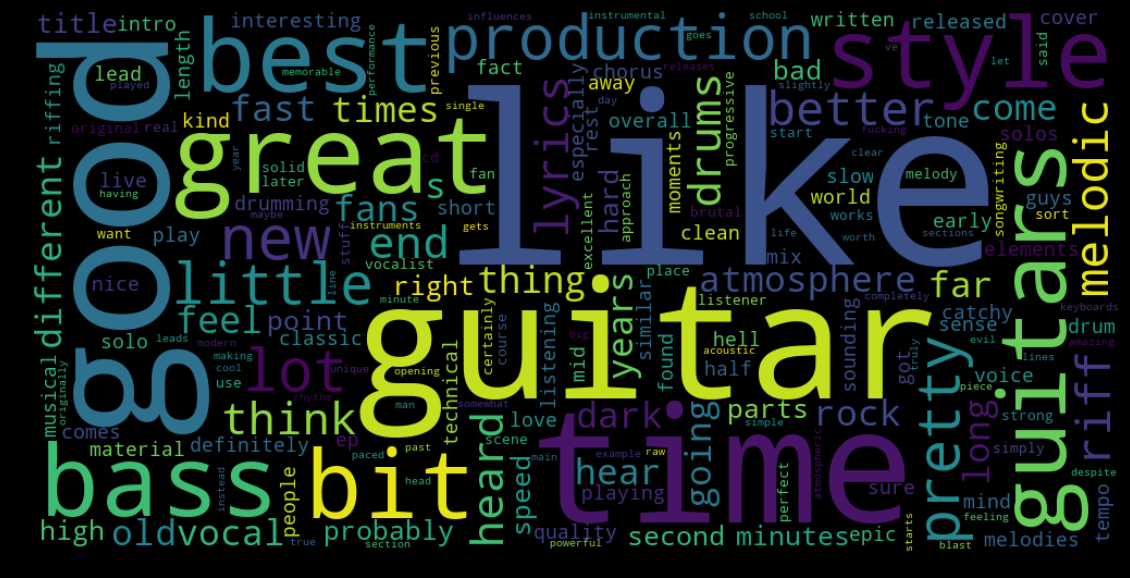

In [274]:
WC_STOP = ['album', 'albums', 'metal', 'music', 'vocals', 'sound', 'actually', 'doom',
           'sounds', 'bands', 'band', 'song', 'songs', 'black', 'death',
           'track', 'riffs', 'tracks', 'record', 'find', 'power', 'things', 'demo',
           'thrash', 'know', 'work', 'makes', 'listen', 'release', 'title' 'end',
           'debut', 'genre', 'heavy', 'nt', 'way']
aword_freq = word_freq
for word in WC_STOP:
    del aword_freq[word]
wc = wordcloud.WordCloud(width=1000, height=500)
wc.fit_words(aword_freq)
plt.figure(figsize=(30,10), facecolor='k')
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()
plt.savefig('wordcloud.png')

In [ ]:
df['review_lemmas'] = df['review_words'].apply(lambda x: ' '.join(get_words(x, lemmatize=True)))

In [377]:
df['review_lemmas'][0]

'introduce band metal storm forum darkthrone clone meet place darkthorne copycat approach darkthrone copy pity evaluate band song skip forward quickly absolutely darkthrone copy copycat clone band capable riff way energetic vivid darkthrone overall music absolutely way fast catchy unlike previous album look know black metal nt know way play stand strong firm offer great deal remarkable material thrashy black metal audience judge repetition track album begin end riff probably grunt think concept album like ulver time ago fire metal interview band state album translate cold death pale dead think good word describe album cold pale black metal probably dead nt wrong claim band 100 original originality arise mix good band stuff combine style arrangement approach like tasting excellently prepared cocktail good drink maybe second create original highly worthy great potential album spirit pace aggressiveness good musicianship important flow thank melodic riff project dark atmosphere melodic us

In [58]:
train_df = df.sample(frac=.90)
dev_df = df.loc[~df.index.isin(train_df.index)]

In [59]:
len(dev_df), len(train_df)

(10063, 90563)

In [60]:
len(dev_df) + len(train_df)

100626

In [61]:
len(df)

100626

In [106]:
tr_df = train_df[['review_lemmas', 'sentiment']]
dv_df = dev_df[['review', 'sentiment']]

In [107]:
train_data = []
for index, row in tr_df.iterrows():
    train_data.append((row['review_lemmas'], row['sentiment']))

In [108]:
dev_data = []
for index, row in dv_df.iterrows():
    dev_data.append((row['review'], row['sentiment']))

In [109]:
dev_data[0]

('\nI was introduced to this band in Metal Storm forums as a Darkthrone clone, met them again at other places as Darkthorne copycats, and see the same approach here as a Darkthrone copy. It is a pity to evaluate this band over a few songs skipped forward quickly, for they are absolutely no Darkthrone copy, copycat, clone or whatever else a band is capable of becoming. They are much more to it. The riffs are way more energetic and vivid than Darkthrone’s, and the overall music is absolutely way too fast and catchy. Unlike their previous album in which they looked as if they knew what Black Metal is but didn’t know in what way to play it; they stand strong and firm here, offering a great deal of remarkable material for the thrashy Black Metal audience. \n\r\nJudging by the repetition in the track names (and album’s beginning and ending with the same riff, and most probably with the same grunt), I think this is a concept album, something like Ulver did some time ago. In Fire Metal’s inter

In [ ]:
from __future__ import unicode_literals, print_function
import plac
import random
from pathlib import Path

import spacy
from spacy.util import minibatch, compounding

@plac.annotations(
    model=("Model name. Defaults to blank 'en' model.", "option", "m", str),
    output_dir=("Optional output directory", "option", "o", Path),
    n_texts=("Number of texts to train from", "option", "t", int),
    n_iter=("Number of training iterations", "option", "n", int))
def train_model(model=None, output_dir=None, n_iter=20, n_texts=2000):
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank('en')  # create blank Language class
        print("Created blank 'en' model")

    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'textcat' not in nlp.pipe_names:
        textcat = nlp.create_pipe('textcat')
        nlp.add_pipe(textcat, last=True)
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe('textcat')

    # add label to text classifier
    textcat.add_label('POSITIVE')

    print("Loading The Metal-Archives data...")
    (train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
    print("Using {} examples ({} training, {} evaluation)"
          .format(n_texts, len(train_texts), len(dev_texts)))
    train_data = list(zip(train_texts,
                          [{'cats': cats} for cats in train_cats]))

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        print("Training the model...")
        print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
        for i in range(n_iter):
            losses = {}
            # batch up the examples using spaCy's minibatch
            batches = minibatch(train_data, size=compounding(4., 32., 1.001))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                           losses=losses)
            with textcat.model.use_params(optimizer.averages):
                # evaluate on the dev data split off in load_data()
                scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
            print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
                  .format(losses['textcat'], scores['textcat_p'],
                          scores['textcat_r'], scores['textcat_f']))

    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        with nlp.use_params(optimizer.averages):
            nlp.to_disk(output_dir)
        print("Saved model to", output_dir)
        
    return nlp

def load_data(limit=0, split=0.8):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    global train_data
    random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0   # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0   # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}

In [124]:
tnlp = train_model(output_dir='data/ma_model1', n_iter=20, n_texts=len(train_data))

Created blank 'en' model
Loading The Metal-Archives data...
Using 90563 examples (72450 training, 18113 evaluation)
Training the model...
LOSS 	  P  	  R  	  F  
514.431	0.839	0.899	0.868
369.110	0.846	0.889	0.867
311.449	0.847	0.881	0.864
276.345	0.847	0.878	0.862
255.272	0.847	0.875	0.861
242.119	0.848	0.874	0.861
233.409	0.846	0.874	0.860
226.124	0.847	0.872	0.860
221.353	0.849	0.872	0.860
217.129	0.848	0.871	0.859
216.234	0.848	0.870	0.859
210.670	0.847	0.870	0.858
209.512	0.847	0.869	0.858
213.043	0.847	0.868	0.857
207.692	0.848	0.868	0.858
208.932	0.847	0.869	0.858
207.611	0.848	0.869	0.858
208.336	0.848	0.869	0.858
205.264	0.847	0.869	0.858
209.148	0.847	0.868	0.858
Saved model to data/ma_model1


In [297]:
mdir = 'data/ma_model1'
print("Loading model {0}".format(mdir))
tnlp = spacy.load(mdir)
print("Evaluating model...")
i = 0
correct = 0
false_positives = []
false_negatives = []
true_positives = []
true_negatives = []
predictions = []
texts, labels = zip(*train_data)
for doc in tnlp.pipe(texts, batch_size=1000, n_threads=4):
    predict = bool(doc.cats['POSITIVE'] >= 0.5)
    predictions.append(int(predict))
    if predict == bool(labels[i]):
        correct += 1
        if predict:
            true_positives.append(i)
        else:
            true_negatives.append(i)
    else:
        if predict:
            false_positives.append(i)
        else:
            false_negatives.append(i)    
    i += 1
print(float(correct)/i)
print("True Positives: {0}".format(len(true_positives)))
print("False Positives: {0}".format(len(false_positives)))
print("True Negatives: {0}".format(len(true_negatives)))
print("False Negatives: {0}".format(len(false_negatives)))
print("Total documents classified: {0}".format(i))

Loading model data/ma_model1
Evaluating model...
0.9160694764970242
True Positives: 51242
False Positives: 4340
True Negatives: 31720
False Negatives: 3261
Total documents classified: 90563


In [299]:
dev_data[0]

("\nSweet jesus there's a lot of brutal death metal bands out there.  I know it's always been a very popular subgenre, but damned if there doesn't seem to have been a ridiculous increase in the number of such bands over the past couple years.  Hailing from Edinburgh, Scotland, Sons Of Slaughter is another one of these bands, laden with enough blasts and tremolos and grrs to please most brutal death fans.  Unfortunately, their debut release 'The Extermination Strain' isn't able to do much more than echo other such releases.\n\r\nAfter a brief ambient intro (apparently a legal necessity for all metal albums these days), the album kicks off with 'Lead Us Not', a derivative, though enjoyable, slab of brutal death.  It's tight and percussive, moving quickly from riff to riff and rhythm to rhythm, maintaining a solid balance of old-school Suffocation emulation with the modern sound we all know and (supposedly) love.  The song grinds along appropriately, and leaves the listener satisfied, tho

In [300]:
mdir = 'data/ma_model1'
tnlp = spacy.load(mdir)
doc = tnlp(df.iloc[0]['review'])

In [304]:
doc.cats['POSITIVE']

0.9868379235267639

In [295]:
mdir = 'data/ma_model1'
print("Loading model {0}".format(mdir))
tnlp = spacy.load(mdir)
print("Evaluating model...")
i = 0
correct = 0
false_positives = []
false_negatives = []
true_positives = []
true_negatives = []
predictions = []
texts, labels = zip(*dev_data)
for doc in tnlp.pipe(texts, batch_size=1000, n_threads=4):
    predict = bool(doc.cats['POSITIVE'] >= 0.5)
    predictions.append(int(predict))
    if predict == bool(labels[i]):
        correct += 1
        if predict:
            true_positives.append(i)
        else:
            true_negatives.append(i)
    else:
        if predict:
            false_positives.append(i)
        else:
            false_negatives.append(i)    
    i += 1
print(float(correct)/i)
print("True Positives: {0}".format(len(true_positives)))
print("False Positives: {0}".format(len(false_positives)))
print("True Negatives: {0}".format(len(true_negatives)))
print("False Negatives: {0}".format(len(false_negatives)))
print("Total documents classified: {0}".format(i))

Loading model data/ma_model1
Evaluating model...
0.9150352777501739
True Positives: 5744
False Positives: 493
True Negatives: 3464
False Negatives: 362
Total documents classified: 10063


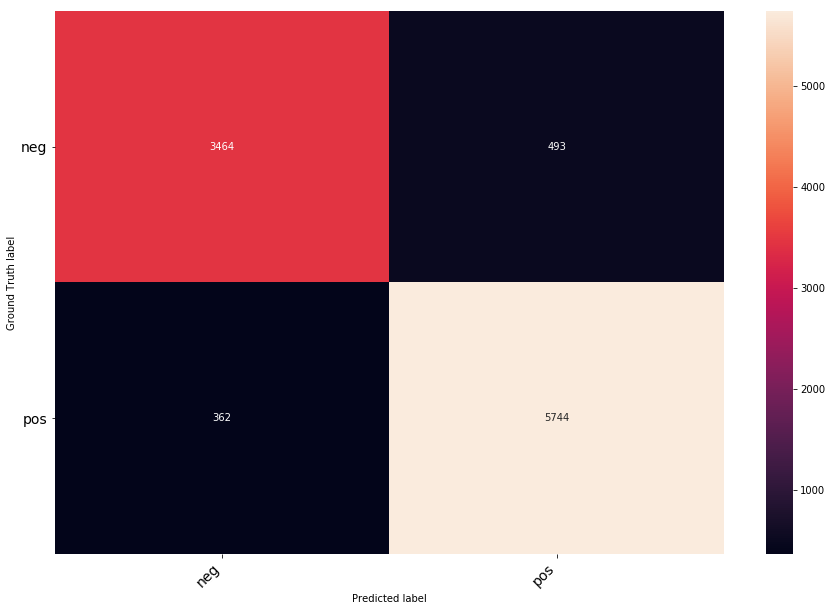

In [296]:
cm = confusion_matrix(dev_labels, predictions)
class_names = ['neg', 'pos']
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
fig = plt.figure(figsize=(15,10))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('Ground Truth label')
plt.xlabel('Predicted label')
plt.show()
heatmap.get_figure().savefig("data/confusion.png")

In [275]:
dev_texts[true_positives[-1]], dev_labels[true_positives[-1]]

('\nIt is a shame that Zyklon B were not around for longer than they were, and it is a shame that they didn\'t release much more material, because this short but sweet EP is absolutely terrific. If you want vicious riffs, grim vocals, and blisteringly fast drumming, this is the EP for you. There may only be a small handful of tracks, but they really pack a punch. Zyklon-B managed to completely master war black metal in only a couple of tracks.\n\nBlood Must Be Shed has a couple of highlights, one fo them being the track it opens up with. This brilliant track, entitled "Mental Orgasm", which features some excellent riffs. The opening riff is abrasive and memorable, being complimented by ultra fast blast beats which sound excellent. As the track evolves, keyboard comes in in the background to compliment the rest of the song. The keyboard may not be as offensive and hard hitting as the rest of the instruments, but it helps tie them together and highlight the melodic undertones. It must be

In [276]:
dev_texts[true_negatives[-1]], dev_labels[true_negatives[-1]]

('\nPerhaps the upwards velocity of the band had been curbed by the year 2006. With two unrelenting hybrids, generally well received slabs of modernist black/death metal attack beneath their belts, what more could the band really offer us? Would they simply turn back towards their mainstays and forget all about this project, or was there something else in the time streams planned for the Zyklon  fan...it turns out this was the case, and keeping the same lineup and style intact from the sophomore Aeon, the Norwegian super group would once more emerge from their caverns of creation to try and bludgeon us upside the head once more.\n\r\nDisintegrate is an anomaly to me, because for all purposes, its contents have been very carefully measured and committed to the studio with a lot of superior elements to the past. These are arguably the band\'s busiest compositions, and some will say their best recorded (though a case might be made for World ov Worm\'s less bassy scenario or Aeon\'s turbul

In [277]:
dev_texts[false_positives[-1]], dev_labels[false_positives[-1]]

('\nWhile it still can\'t match World ov Worms, Disintegrate makes a concerted effort to rectify many of the pitfalls introduced on the lackluster Aeon, and at the very least ends Zyklon\'s career on a relatively high note. These compositions are stuffed to the brim with multiple shifts in both tone and delivery, being lively without necessarily becoming hectic and chaotic. The production values are also top notch this time around, lending a deservedly massive sonic palette to the proceedings that help amplify the snappy nature of Torson\'s kit alongside the windswept tremolo barrage.\n\r\nSechtdamon even impresses this time around, sparingly radiating a number of disparate vocal styles not limited to his sepulchral death roars. He delivers some of the half-shouting melodic passages that hail back to Daemon\'s fiendish inflection from World ov Worms. While I could easily stack Disintegrate up to Zyklon\'s spectacular debut and highlight all of the reasons it still falls short, that wou

In [278]:
dev_texts[false_negatives[-1]], dev_labels[false_negatives[-1]]

("\nI was pleasantly surprised when I approved this band on the Archives, they're an original act with a fun name, a distinctive approach and a great aptitude at mixing genres. Way better than the usual groove or deathcore crap we often deal with!They were classified by a long blurb of terms that rarely go well together, something like ''blues rock and roll black metal'', I decided to change it to ''black metal'' but that's almost oversimplifying things. In their words, the band play ''sleazy n' cheesy bluesy rockin' black metal'' and that's totally accurate. There's not a lot of bands that could play a better rendition of this style.\n\r\nAfter a pointless intro of 1 minute, the first song starts with a bang. With its twelve minutes, ''Skull Shaped Bell'' is perhaps the best song on the release, encompassing the band's genre very well. The band has this jam vibe that's really really nice obviously influenced by acid and psychedelic rock. We can feel the touch of Roky Erickson, Gratefu

In [231]:
# t-SNE
#
# Notes: https://distill.pub/2016/misread-tsne/
from gensim.models import word2vec
from sklearn.manifold import TSNE

corpus = []
_ = df['review_words'].apply(lambda x: corpus.append(x.split()))
model = word2vec.Word2Vec(corpus, size=300, window=20, min_count=500, workers=16)
labels = []
tokens = []

for word in model.wv.vocab:
    tokens.append(model.__getitem__(word))
    labels.append(word)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [232]:
tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000, random_state=23)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
vdf = pd.DataFrame.from_dict({'x': x, 'y': y, 'labels': labels})

In [271]:
p = figure(plot_width=1000, plot_height=500, toolbar_location=None)
p.circle('x', 'y', size=5, color="firebrick", source=vdf, alpha=0.5)
p.add_layout(Title(text="t-SNE Word Map", align="center"), "below") 
p.add_tools(HoverTool(tooltips="@labels"))
p.xgrid.visible = False
p.ygrid.visible = False
p.xaxis.visible = False
p.yaxis.visible = False
show(p)

In [272]:
html = file_html(p, CDN, "tsne-plot")
with open('data/tsne-plot.html', 'w') as f:
    f.write(html)

In [279]:
df10 = df.sample(frac=.1)
df90 = df[~df.index.isin(df10.index)]

In [280]:
data = {}
labels = {}
for data_type in ["test", "train"]:
    data[data_type] = {}
    labels[data_type] = {}
    for sentiment in ['pos', 'neg']:
        data[data_type][sentiment] = []
        labels[data_type][sentiment] = []

In [281]:
for i in df10.index:
    if df10.loc[i, "sentiment"] == 1:
        data["test"]["pos"].append(df10.loc[i, "review"])
    else:
        data["test"]["neg"].append(df10.loc[i, "review"])
labels["test"]["pos"] = [1] * len(data["test"]["pos"])
labels["test"]["neg"] = [0] * len(data["test"]["neg"])
print("Positive test reviews: {0}, Negative test reviews: {1}". format(len(data["test"]["pos"]), len(data["test"]["neg"])))

Positive test reviews: 6106, Negative test reviews: 3957


In [282]:
for i in df90.index:
    if df90.loc[i, "sentiment"] == 1:
        data["train"]["pos"].append(df90.loc[i, "review"])
    else:
        data["train"]["neg"].append(df90.loc[i, "review"])
labels["train"]["pos"] = [1] * len(data["train"]["pos"])
labels["train"]["neg"] = [0] * len(data["train"]["neg"])
print("Positive training reviews: {0}, Negative training reviews: {1}". format(len(data["train"]["pos"]), len(data["train"]["neg"])))

Positive training reviews: 54503, Negative training reviews: 36060


In [283]:
def prepare_ma_data(data):
    """Prepare training and test sets from MA reviews."""
    
    data_train = data['train']['pos']+data['train']['neg']
    data_test = data['test']['pos']+data['test']['neg']
    labels_train = [1]*len(data['train']['pos'])+[0]*len(data['train']['neg'])
    labels_test = [1]*len(data['test']['pos'])+[0]*len(data['test']['neg'])
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

data_train, data_test, labels_train, labels_test = prepare_ma_data(data)
print("MA reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

MA reviews (combined): train = 90563, test = 10063


In [284]:
words_train = df90[df90.sentiment == 1]['review_lemmas'].values.tolist() + df90[df90.sentiment == 0]['review_lemmas'].values.tolist()
words_test = df10[df10.sentiment == 1]['review_lemmas'].values.tolist() + df10[df10.sentiment == 0]['review_lemmas'].values.tolist()

In [285]:
vectorizer = CountVectorizer(preprocessor = lambda x:x, tokenizer = lambda x: x.split())
features_train = vectorizer.fit_transform(words_train)
features_test = vectorizer.transform(words_test)
features_train = pr.normalize(features_train)
features_test = pr.normalize(features_test)

In [286]:
for clf in [MultinomialNB(), LinearSVC()]:
    clf.fit(features_train, labels_train)
    print("[{}] Accuracy: train = {}, test = {}".format(
        clf.__class__.__name__,
        clf.score(features_train, labels_train),
        clf.score(features_test, labels_test)))

[MultinomialNB] Accuracy: train = 0.6018241445181807, test = 0.6067773029911557
[LinearSVC] Accuracy: train = 0.720526042644347, test = 0.5620590281228262


In [287]:
def create_tuple(review, sentiment, lst):
    lst.append((review, sentiment))

In [291]:
train_data = []
_ = df90.apply(lambda row: create_tuple(row['review'], row['sentiment'], train_data), axis=1)
dev_data = []
_ = df10.apply(lambda row: create_tuple(row['review'], row['sentiment'], dev_data), axis=1)

In [292]:
import plac
import random
import pathlib
import cytoolz
import numpy
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam
import thinc.extra.datasets
from spacy.compat import pickle

class SentimentAnalyser(object):
    @classmethod
    def load(cls, path, nlp, max_length=100):
        with open(path / 'config.json') as file_:
            model = model_from_json(file_.read())
        with open(path / 'model', 'rb') as file_:
            lstm_weights = pickle.load(file_)
        embeddings = get_embeddings(nlp.vocab)
        model.set_weights([embeddings] + lstm_weights)
        return cls(model, max_length=max_length)

    def __init__(self, model, max_length=100):
        self._model = model
        self.max_length = max_length

    def __call__(self, doc):
        X = get_features([doc], self.max_length)
        y = self._model.predict(X)
        self.set_sentiment(doc, y)

    def pipe(self, docs, batch_size=1000, n_threads=2):
        for minibatch in cytoolz.partition_all(batch_size, docs):
            minibatch = list(minibatch)
            sentences = []
            for doc in minibatch:
                sentences.extend(doc.sents)
            Xs = get_features(sentences, self.max_length)
            ys = self._model.predict(Xs)
            for sent, label in zip(sentences, ys):
                sent.doc.sentiment += label - 0.5
            for doc in minibatch:
                yield doc

    def set_sentiment(self, doc, y):
        doc.sentiment = float(y[0])
        # Sentiment has a native slot for a single float.
        # For arbitrary data storage, there's:
        # doc.user_data['my_data'] = y


def get_labelled_sentences(docs, doc_labels):
    labels = []
    sentences = []
    for doc, y in zip(docs, doc_labels):
        for sent in doc.sents:
            sentences.append(sent)
            labels.append(y)
    return sentences, numpy.asarray(labels, dtype='int32')


def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs


def train(train_texts, train_labels, dev_texts, dev_labels,
          lstm_shape, lstm_settings, lstm_optimizer, batch_size=100,
          nb_epoch=5, by_sentence=True):
    
    print("Loading spaCy")
    nlp = spacy.load('en_vectors_web_lg')
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    embeddings = get_embeddings(nlp.vocab)
    model = compile_lstm(embeddings, lstm_shape, lstm_settings)
    
    print("Parsing texts...")
    train_docs = list(nlp.pipe(train_texts))
    dev_docs = list(nlp.pipe(dev_texts))
    if by_sentence:
        train_docs, train_labels = get_labelled_sentences(train_docs, train_labels)
        dev_docs, dev_labels = get_labelled_sentences(dev_docs, dev_labels)

    train_X = get_features(train_docs, lstm_shape['max_length'])
    dev_X = get_features(dev_docs, lstm_shape['max_length'])
    model.fit(train_X, train_labels, validation_data=(dev_X, dev_labels),
              epochs=nb_epoch, batch_size=batch_size)
    return model


def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape['max_length'],
            trainable=False,
            weights=[embeddings],
            mask_zero=True
        )
    )
    model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False)))
    model.add(Bidirectional(LSTM(shape['nr_hidden'],
                                 recurrent_dropout=settings['dropout'],
                                 dropout=settings['dropout'])))
    model.add(Dense(shape['nr_class'], activation='sigmoid'))
    model.compile(optimizer=Adam(lr=settings['lr']), loss='binary_crossentropy', metrics=['accuracy'])
    return model


def get_embeddings(vocab):
    return vocab.vectors.data


def evaluate(model_dir, texts, labels, max_length=100):
    nlp = spacy.load('en_vectors_web_lg')
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    print("Loading model...")
    nlp.add_pipe(SentimentAnalyser.load(model_dir, nlp, max_length=max_length))

    correct = 0
    i = 0
    print("Evaluating model...")
    for doc in nlp.pipe(texts, batch_size=1000, n_threads=4):
        correct += bool(doc.sentiment >= 0.5) == bool(labels[i])
        i += 1
    return float(correct) / i


def read_data(data_dir, limit=0):
    examples = []
    for subdir, label in (('pos', 1), ('neg', 0)):
        for filename in (data_dir / subdir).iterdir():
            with filename.open() as file_:
                text = file_.read()
            examples.append((text, label))
    random.shuffle(examples)
    if limit >= 1:
        examples = examples[:limit]
    return zip(*examples) # Unzips into two list

@plac.annotations(
    train_dir=("Location of training file or directory"),
    dev_dir=("Location of development file or directory"),
    model_dir=("Location of output model directory",),
    is_runtime=("Demonstrate run-time usage", "flag", "r", bool),
    nr_hidden=("Number of hidden units", "option", "H", int),
    max_length=("Maximum sentence length", "option", "L", int),
    dropout=("Dropout", "option", "d", float),
    learn_rate=("Learn rate", "option", "e", float),
    nb_epoch=("Number of training epochs", "option", "i", int),
    batch_size=("Size of minibatches for training LSTM", "option", "b", int),
    nr_examples=("Limit to N examples", "option", "n", int)
)
def sentiment_analyzer(model_dir=None, train_dir=None, dev_dir=None,
         is_runtime=False,
         nr_hidden=64, max_length=100, # Shape
         dropout=0.5, learn_rate=0.001, # General NN config
         nb_epoch=10, batch_size=256, nr_examples=-1):  # Training params
    if model_dir is not None:
        model_dir = pathlib.Path(model_dir)
    if is_runtime:
        if dev_dir is None:
            dev_texts, dev_labels = zip(*dev_data)
        else:
            dev_texts, dev_labels = read_data(dev_dir)
        acc = evaluate(model_dir, dev_texts, dev_labels, max_length=max_length)
        print(acc)
    else:
        if train_dir is None:
            random.shuffle(train_data)
            train_texts, train_labels = zip(*train_data)
        else:
            print("Read data")
            train_texts, train_labels = read_data(train_dir, limit=nr_examples)
        if dev_dir is None:
            random.shuffle(dev_data)
            dev_texts, dev_labels = zip(*dev_data)
        else:
            dev_texts, dev_labels = read_data(dev_dir, limit=nr_examples)
        train_labels = numpy.asarray(train_labels, dtype='int32')
        dev_labels = numpy.asarray(dev_labels, dtype='int32')
        lstm = train(train_texts, train_labels, dev_texts, dev_labels,
                     {'nr_hidden': nr_hidden, 'max_length': max_length, 'nr_class': 1},
                     {'dropout': dropout, 'lr': learn_rate},
                     {},
                     nb_epoch=nb_epoch, batch_size=batch_size)
        weights = lstm.get_weights()
        if model_dir is not None:
            with (model_dir / 'model').open('wb') as file_:
                pickle.dump(weights[1:], file_)
            with (model_dir / 'config.json').open('w') as file_:
                file_.write(lstm.to_json())

In [293]:
sentiment_analyzer(model_dir='data/ma_model_h', is_runtime=True)

Loading model...
Evaluating model...
0.8065189307363609
